# Tempogram: Fourier, Autocorrelation, Cyclic

Compute three tempogram variants (Fourier, autocorrelation, cyclic) from the spectral novelty function for YTB-013 HEAD_IN, using [FMP C6S2_TempogramFourier](notebooks/fmp/C6S2_TempogramFourier.ipynb), [C6S2_TempogramAutocorrelation](notebooks/fmp/C6S2_TempogramAutocorrelation.ipynb), and [C6S2_TempogramCyclic](notebooks/fmp/C6S2_TempogramCyclic.ipynb) as reference.

In [1]:
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from scipy.interpolate import interp1d

# Add project root for dijon imports
project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import DERIVED_DIR, RAW_AUDIO_DIR

%matplotlib inline

In [2]:
def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    """Compute local autocorrelation [FMP, Section 6.2.3].

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb
    """
    L_left = round(N / 2)
    L_right = L_left
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    A = np.zeros((N, M))
    win = np.ones(N)
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        x_local = win * x_pad[t_0:t_1]
        r_xx = np.correlate(x_local, x_local, mode="full")
        r_xx = r_xx[N - 1 :]
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        A[:, n] = r_xx
    T_coef = np.arange(A.shape[1]) * H / Fs
    F_coef_lag = np.arange(N) / Fs
    return A, T_coef, F_coef_lag


def compute_tempogram_autocorr(x, Fs, N, H, norm_sum=False, Theta=None):
    """Compute autocorrelation-based tempogram [FMP, Section 6.2.3]."""
    if Theta is None:
        Theta = np.arange(40, 321)
    tempo_min, tempo_max = Theta[0], Theta[-1]
    lag_min = int(np.ceil(Fs * 60 / tempo_max))
    lag_max = int(np.ceil(Fs * 60 / tempo_min))
    A, T_coef, F_coef_lag = compute_autocorrelation_local(x, Fs, N, H, norm_sum=norm_sum)
    A_cut = A[lag_min : lag_max + 1, :]
    F_coef_lag_cut = F_coef_lag[lag_min : lag_max + 1]
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    tempogram = interp1d(
        F_coef_BPM_cut, A_cut, kind="linear", axis=0, fill_value="extrapolate"
    )(Theta)
    return tempogram, T_coef, Theta


def compute_cyclic_tempogram(tempogram, F_coef_BPM, tempo_ref=40, octave_bin=40, octave_num=4):
    """Compute cyclic tempogram [FMP, Section 6.2.4].

    Notebook: C6/C6S2_TempogramCyclic.ipynb
    """
    F_coef_BPM_log = tempo_ref * np.power(2, np.arange(0, octave_num * octave_bin) / octave_bin)
    F_coef_scale = np.power(2, np.arange(0, octave_bin) / octave_bin)
    tempogram_log = interp1d(
        F_coef_BPM, tempogram, kind="linear", axis=0, fill_value="extrapolate"
    )(F_coef_BPM_log)
    K = len(F_coef_BPM_log)
    tempogram_cyclic = np.zeros((octave_bin, tempogram.shape[1]))
    for m in range(octave_bin):
        tempogram_cyclic[m, :] = np.mean(tempogram_log[m:K:octave_bin, :], axis=0)
    return tempogram_cyclic, F_coef_scale

In [3]:
@jit(nopython=True)
def compute_tempogram_fourier(x, Fs, N, H, Theta):
    """Compute Fourier-based tempogram [FMP, Section 6.2.2].

    Notebook: C6/C6S2_TempogramFourier.ipynb

    Args:
        x (np.ndarray): Input signal (novelty function)
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM)

    Returns:
        X (np.ndarray): Tempogram
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_BPM (np.ndarray): Tempo axis (BPM)
    """
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    K = len(Theta)
    X = np.zeros((K, M), dtype=np.complex128)

    for k in range(K):
        omega = (Theta[k] / 60) / Fs
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        x_exp = x_pad * exponential
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            X[k, n] = np.sum(win * x_exp[t_0:t_1])
    T_coef = np.arange(M) * H / Fs
    F_coef_BPM = Theta
    return X, T_coef, F_coef_BPM

In [4]:
TRACK = "YTB-013"
MARKER = "HEAD_IN"
FS_NOV = 100  # target feature rate for tempogram (matches FMP reference)
H_SPECTRAL = 256  # hop size used when computing spectral novelty in novelty.ipynb

# Load spectral novelty only
novelty_path = DERIVED_DIR / "novelty" / f"{TRACK}_{MARKER}_spectral.npy"
novelty_spec = np.load(novelty_path)

# Get sample rate from audio to compute original feature rate
audio_path = RAW_AUDIO_DIR / f"{TRACK}.wav"
_, sr = librosa.load(audio_path, sr=None, mono=True, duration=0.1)
Fs_spec = sr / H_SPECTRAL

# Resample novelty to 100 Hz
t_in = np.arange(len(novelty_spec)) / Fs_spec
duration_s = len(novelty_spec) / Fs_spec
n_out = int(duration_s * FS_NOV)
t_out = np.linspace(0, duration_s, n_out, endpoint=False)
interp = interp1d(t_in, novelty_spec, kind="linear", fill_value="extrapolate")
nov = interp(t_out).astype(np.float64)
print(f"Spectral novelty: {len(novelty_spec)} frames @ {Fs_spec:.1f} Hz -> {len(nov)} @ {FS_NOV} Hz")

Spectral novelty: 2677 frames @ 86.1 Hz -> 3107 @ 100 Hz


In [5]:
N = 500  # 5 seconds at 100 Hz
H = 10
Theta = np.arange(40, 321, dtype=np.float64)  # 40–320 BPM

# Fourier tempogram
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, FS_NOV, N=N, H=H, Theta=Theta)
tempogram_fourier = np.abs(X)

# Autocorrelation tempogram
tempogram_autocorr, T_coef_A, F_coef_BPM_A = compute_tempogram_autocorr(
    nov, FS_NOV, N=N, H=H, Theta=Theta
)

# Cyclic tempogram (built from Fourier tempogram)
tempogram_cyclic, F_coef_scale = compute_cyclic_tempogram(
    tempogram_fourier, F_coef_BPM, tempo_ref=40, octave_bin=40, octave_num=4
)

/var/folders/n3/fk41_zd57m79jjjprfznr8680000gn/T/ipykernel_15196/809802019.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


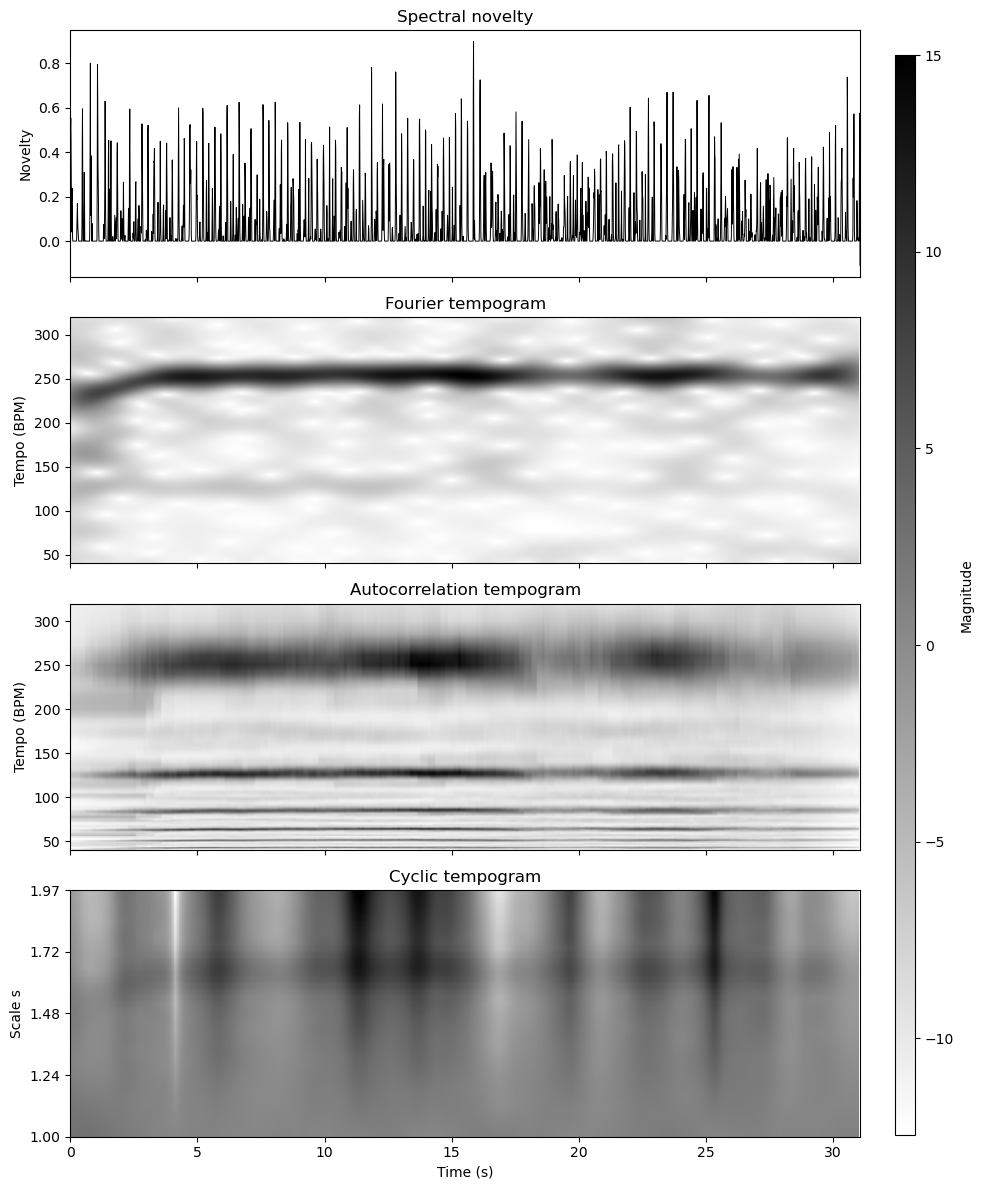

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

t_nov = np.arange(len(nov)) / FS_NOV

# Novelty function
axes[0].plot(t_nov, nov, "k", linewidth=0.7)
axes[0].set_title("Spectral novelty")
axes[0].set_xlim(0, t_nov[-1])
axes[0].set_ylabel("Novelty")

# Fourier tempogram
im1 = axes[1].imshow(
    tempogram_fourier,
    aspect="auto",
    origin="lower",
    extent=[T_coef[0], T_coef[-1], F_coef_BPM[0], F_coef_BPM[-1]],
    cmap="gray_r",
)
axes[1].set_title("Fourier tempogram")
axes[1].set_ylabel("Tempo (BPM)")

# Autocorrelation tempogram
im2 = axes[2].imshow(
    tempogram_autocorr,
    aspect="auto",
    origin="lower",
    extent=[T_coef_A[0], T_coef_A[-1], F_coef_BPM_A[0], F_coef_BPM_A[-1]],
    cmap="gray_r",
)
axes[2].set_title("Autocorrelation tempogram")
axes[2].set_ylabel("Tempo (BPM)")

# Cyclic tempogram (y-axis: scale factor s in [1, 2))
im3 = axes[3].imshow(
    tempogram_cyclic,
    aspect="auto",
    origin="lower",
    extent=[T_coef[0], T_coef[-1], F_coef_scale[0], F_coef_scale[-1]],
    cmap="gray_r",
)
axes[3].set_title("Cyclic tempogram")
axes[3].set_xlabel("Time (s)")
axes[3].set_ylabel("Scale s")
yticks = np.linspace(F_coef_scale[0], F_coef_scale[-1], 5)
axes[3].set_yticks(yticks)
axes[3].set_yticklabels([f"{y:.2f}" for y in yticks])

cax = fig.add_axes([0.9, 0.05, 0.02, 0.9])
fig.colorbar(im3, cax=cax, label="Magnitude")
plt.tight_layout(rect=[0, 0, 0.88, 1])

In [7]:
# Save tempograms to data/derived/tempogram (naming: {TRACK}_{MARKER}_{variant}.npy)
tempogram_dir = DERIVED_DIR / "tempogram"
tempogram_dir.mkdir(parents=True, exist_ok=True)
np.save(tempogram_dir / f"{TRACK}_{MARKER}_fourier.npy", tempogram_fourier)
np.save(tempogram_dir / f"{TRACK}_{MARKER}_autocorr.npy", tempogram_autocorr)
np.save(tempogram_dir / f"{TRACK}_{MARKER}_cyclic.npy", tempogram_cyclic)